## TRAINNING LSTM & XGBOOST

In [1]:
import os
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
from tqdm import tqdm

In [2]:
mongo_client = MongoClient(
    "mongodb://127.0.0.1:27017/",
    serverSelectionTimeoutMS=60000,  # 60s
    connectTimeoutMS=60000
)

mongo_db = mongo_client["traffic"]
features_coll = mongo_db["traffic_features"]

In [3]:
mongo_client

MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True, serverselectiontimeoutms=60000, connecttimeoutms=60000)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [5]:
required_columns = [
    'year','month','hour','day_of_week','is_weekend',
    'road_type','region_name','local_authority_name','road_name','link_length_km',
    'pedal_cycles','two_wheeled_motor_vehicles','cars_and_taxis','buses_and_coaches',
    'lgvs','hgvs_2_rigid_axle','all_hgvs','all_motor_vehicles'
]

In [6]:
# Tạo projection dictionary: {tên_trường: 1} để bao gồm
projection = {col: 1 for col in required_columns}
projection['_id'] = 0  # Thường thì không cần _id, loại bỏ nó sẽ giảm tải

print("Đang tải dữ liệu từ MongoDB với projection...")
# Thêm projection vào câu lệnh find()
cursor = features_coll.find({}, projection)
df = pd.DataFrame(list(cursor))
print(f"Tải thành công {len(df)} bản ghi.")

Đang tải dữ liệu từ MongoDB với projection...
Tải thành công 4253812 bản ghi.


In [7]:
# --- Xử lý dữ liệu ---
features = [
    "hour", "month", "is_weekend",
    "pedal_cycles", "two_wheeled_motor_vehicles",
    "cars_and_taxis", "buses_and_coaches", "lgvs",
    "hgvs_2_rigid_axle", "all_hgvs"
]

categorical_cols = ["day_of_week", "road_type", "region_name", "local_authority_name"]
target = "all_motor_vehicles"

In [8]:
# Chuyển numeric columns
numeric_cols = features + [target, 'year','link_length_km']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.fillna(0, inplace=True)

In [9]:
# Encode categorical
label_encoders = {}
for col in categorical_cols + ['road_name']:
    le = LabelEncoder()
    df[col+'_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    features.append(col+'_encoded')

print(f"✅ Features cuối cùng: {features}")


✅ Features cuối cùng: ['hour', 'month', 'is_weekend', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle', 'all_hgvs', 'day_of_week_encoded', 'road_type_encoded', 'region_name_encoded', 'local_authority_name_encoded', 'road_name_encoded']


In [10]:
# --- LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [11]:
# --- Huấn luyện LSTM theo road_name ---
df = df.sort_values(by=['road_name_encoded','year','month','hour']).reset_index(drop=True)
unique_roads = df['road_name_encoded'].unique()
all_lstm_results = []
n_steps = 5


In [12]:
for road in tqdm(unique_roads, desc="Huấn luyện LSTM theo road_name"):
    df_road = df[df['road_name_encoded'] == road].copy()
    if len(df_road) < n_steps + 15:
        continue

    data_to_scale = df_road[features + [target]]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_to_scale)

    X_lstm, y_lstm = [], []
    for i in range(len(scaled_data) - n_steps):
        X_lstm.append(scaled_data[i:i+n_steps, :-1])
        y_lstm.append(scaled_data[i+n_steps, -1])

    if len(X_lstm) == 0:
        continue

    X_tensor = torch.FloatTensor(np.array(X_lstm)).to(device)
    y_tensor = torch.FloatTensor(np.array(y_lstm)).unsqueeze(1).to(device)
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    model_lstm = LSTMModel(input_size=X_tensor.shape[2]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
    num_epochs = 5

    for epoch in range(num_epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model_lstm(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Dự báo và khôi phục giá trị gốc
    batch_size_pred = 64
    predicted_scaled_list = []

    model_lstm.eval()
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size_pred):
            batch = X_tensor[i:i+batch_size_pred]
            batch_pred = model_lstm(batch).cpu().numpy()
            predicted_scaled_list.append(batch_pred)

    predicted_scaled = np.vstack(predicted_scaled_list)
    inverse_helper = np.zeros((len(predicted_scaled), len(features)+1))
    inverse_helper[:, -1] = predicted_scaled.flatten()
    predicted_volume_lstm = scaler.inverse_transform(inverse_helper)[:, -1]

    df_road_result = df_road.iloc[n_steps:].copy()
    df_road_result['lstm_predicted_volume'] = predicted_volume_lstm
    all_lstm_results.append(df_road_result)

# Ghép kết quả
df_stacked = pd.concat(all_lstm_results, ignore_index=True)
print(f"✅ Đã tạo feature từ LSTM: {df_stacked.shape}")

Huấn luyện LSTM theo road_name: 100%|██████████| 3758/3758 [12:03<00:00,  5.19it/s] 


✅ Đã tạo feature từ LSTM: (4234952, 24)


In [13]:
# --- Huấn luyện XGBoost ---
features_for_xgb = features + ['lstm_predicted_volume']
X = df_stacked[features_for_xgb]
y = df_stacked[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_xgb_stacked = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist' if device.type == 'cuda' else 'auto'
)

model_xgb_stacked.fit(X_train, y_train, eval_set=[(X_test,y_test)], verbose=100)

# Đánh giá
y_pred = model_xgb_stacked.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"✅ XGBoost - MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")

c:\Users\DELL\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:07:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-rmse:785.48876
[100]	validation_0-rmse:38.33429
[200]	validation_0-rmse:35.98716
[300]	validation_0-rmse:35.28267
[400]	validation_0-rmse:34.87607
[500]	validation_0-rmse:34.57488
[600]	validation_0-rmse:34.44961
[700]	validation_0-rmse:34.30104
[800]	validation_0-rmse:34.21840
[900]	validation_0-rmse:34.16403
[999]	validation_0-rmse:34.12004


c:\Users\DELL\miniconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [18:08:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\DELL\miniconda3\Lib\site-packages\xgboost\core.py:729: UserWarning: [18:08:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


✅ XGBoost - MSE: 1164.18, RMSE: 34.12, R2: 0.9983


In [32]:
# --- Lưu model & scaler ---
os.makedirs("model", exist_ok=True)
torch.save(model_lstm.state_dict(), "model1/model_lstm_road.pth")
joblib.dump(scaler, "model1/scaler_road.pkl")
joblib.dump(label_encoders, "model1/label_encoders_road.pkl")
joblib.dump(model_xgb_stacked, "model1/model_xgb_stacked_road.pkl")
model_xgb_stacked.save_model("model1/model_xgb_stacked_road.json")
print("✅ Lưu toàn bộ model và scaler thành công.")

c:\Users\DELL\miniconda3\Lib\pickle.py:572: UserWarning: [18:22:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  rv = reduce(self.proto)


✅ Lưu toàn bộ model và scaler thành công.


In [11]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load scaler, label encoders, LSTM model, XGBoost model
scaler = joblib.load("model1/scaler_road.pkl")
label_encoders = joblib.load("model1/label_encoders_road.pkl")
model_xgb_stacked = joblib.load("model1/model_xgb_stacked_road.pkl")

In [12]:
# Khởi tạo LSTM và load state_dict
input_size = len(scaler.feature_names_in_) - 1  # -1 vì target không tính vào input
model_lstm = LSTMModel(input_size=input_size).to(device)
model_lstm.load_state_dict(torch.load("model1/model_lstm_road.pth", map_location=device))
model_lstm.eval()


C:\Users\DELL\AppData\Local\Temp\ipykernel_26524\3679464621.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_lstm.load_state_dict(torch.load("model1/model_lstm_road

LSTMModel(
  (lstm): LSTM(15, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
# --- Chuẩn bị LSTM ---
features_lstm = ['year', 'hour', 'region_name_encoded', 'local_authority_name_encoded',
                 'road_name_encoded', 'road_type_encoded', 'link_length_km',
                 'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
                 'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle', 'all_hgvs', 'all_motor_vehicles']

target_col = 'all_motor_vehicles'  # cột LSTM dự đoán

scaler_lstm = MinMaxScaler()
scaler_lstm.fit(df[features_lstm]) 

MinMaxScaler()

In [14]:
def predict_next_day(road_name, df, model_lstm, model_xgb, scaler_lstm,
                     features_lstm, target_col, n_steps, device):
    # --- Lọc dữ liệu của đường cần dự đoán ---
    df_road = df[df['road_name'] == road_name].sort_values('hour').reset_index(drop=True)
    last_n_data = df_road[features_lstm].iloc[-n_steps:].copy()

    lstm_preds = []

    for i in range(24):
        # Update giờ
        last_n_data['hour'] = (last_n_data['hour'] + 1) % 24

        # Nếu bạn có các cột thời gian khác, cập nhật ở đây

        # Scale và predict
        X_input_scaled = pd.DataFrame(scaler_lstm.transform(last_n_data), columns=features_lstm)
        X_input_tensor = torch.tensor(X_input_scaled.values.astype(np.float32)).unsqueeze(0).to(device)

        model_lstm.eval()
        with torch.no_grad():
            lstm_pred = model_lstm(X_input_tensor).cpu().numpy().flatten()[0]
        lstm_preds.append(lstm_pred)

        # Shift target
        last_n_data = last_n_data.shift(-1)
        last_n_data.iloc[-1, last_n_data.columns.get_loc(target_col)] = lstm_pred

    # --- Tạo DataFrame kết quả 24h ---
    df_next = pd.DataFrame({'hour': np.arange(24)})

    # Các cột input cho XGBoost
    xgb_features = [
        'hour', 'month', 'is_weekend', 'pedal_cycles', 'two_wheeled_motor_vehicles',
        'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle', 'all_hgvs',
        'day_of_week_encoded', 'road_type_encoded', 'region_name_encoded',
        'local_authority_name_encoded', 'road_name_encoded', 'lstm_predicted_volume'
    ]

    # Điền các cột thiếu từ hàng cuối cùng của df_road, ngoại trừ lstm_predicted_volume
    for col in xgb_features:
        if col != 'lstm_predicted_volume' and col not in df_next.columns:
            df_next[col] = df_road[col].iloc[-1]

    # Thêm cột LSTM dự đoán
    df_next['lstm_predicted_volume'] = lstm_preds

    # --- Dự đoán XGBoost ---
    df_next['predicted_volume'] = model_xgb.predict(df_next[xgb_features])

    # --- Gán congestion_level ---
    df_next['congestion_level'] = df_next['predicted_volume'].apply(
        lambda v: '1 - Rất thông thoáng' if v < 100 else
                  '2 - Thông thoáng' if v < 250 else
                  '3 - Bình thường' if v < 400 else
                  '4 - Đông' if v < 600 else '5 - Rất đông'
    )

    return df_next


In [16]:
df_pred = predict_next_day(
    road_name='A1019',
    df=df,
    model_lstm=model_lstm,
    model_xgb=model_xgb_stacked,
    scaler_lstm=scaler_lstm,
    features_lstm=features_lstm,
    target_col='all_motor_vehicles',
    n_steps=5,
    device=device
)

# In kết quả
print(df_pred[['hour', 'predicted_volume', 'congestion_level']])


    hour  predicted_volume congestion_level
0      0        516.563171         4 - Đông
1      1        578.632935         4 - Đông
2      2        578.632935         4 - Đông
3      3        578.632935         4 - Đông
4      4        578.632935         4 - Đông
5      5        578.632935         4 - Đông
6      6        578.632935         4 - Đông
7      7        578.632935         4 - Đông
8      8        612.014893     5 - Rất đông
9      9        631.340820     5 - Rất đông
10    10        631.004272     5 - Rất đông
11    11        631.202087     5 - Rất đông
12    12        631.463440     5 - Rất đông
13    13        631.782410     5 - Rất đông
14    14        632.671570     5 - Rất đông
15    15        610.911255     5 - Rất đông
16    16        627.951538     5 - Rất đông
17    17        627.671204     5 - Rất đông
18    18        627.279419     5 - Rất đông
19    19        627.279419     5 - Rất đông
20    20        627.279419     5 - Rất đông
21    21        627.279419     5

In [55]:
print(df.columns.tolist())


['year', 'hour', 'region_name', 'local_authority_name', 'road_name', 'road_type', 'link_length_km', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle', 'all_hgvs', 'all_motor_vehicles', 'day_of_week', 'is_weekend', 'month', 'day_of_week_encoded', 'road_type_encoded', 'region_name_encoded', 'local_authority_name_encoded', 'road_name_encoded']


In [74]:
# Lấy tất cả các road_name duy nhất
road_names = df['road_name'].unique()
print(road_names)

# Nếu muốn in từng dòng một
for road in road_names:
    print(road)


['A1' 'A1(M)' 'A1(T)' ... 'M9' 'M90' 'U']
A1
A1(M)
A1(T)
A10
A100
A1000
A1001
A1003
A1004
A1005
A1006
A1008
A1009
A101
A1010
A1011
A1012
A1013
A1014
A1015
A1016
A1017
A1018
A1019
A102
A1020
A1021
A1022
A1023
A1024
A1025
A1027
A1028
A1029
A103
A1031
A1032
A1033
A1034
A1035
A1036
A1037
A1038
A1039
A104
A1041
A1042
A1043
A1044
A1045
A1046
A1048
A1049
A105
A1052
A1053
A1054
A1055
A1056
A1057
A1058
A1059
A106
A1060
A1061
A1062
A1064
A1065
A1066
A1067
A1068
A1069
A107
A1070
A1071
A1072
A1073
A1074
A1075
A1076
A1077
A1078
A1079
A1080
A1081
A1082
A1083
A1084
A1085
A1086
A1087
A1088
A1089
A109
A1090
A1092
A1094
A1095
A1096
A1098
A1099
A11
A110
A1101
A1103
A1104
A1105
A1107
A1108
A111
A1110
A1111
A1112
A1114
A1117
A112
A1120
A1121
A1122
A1123
A1124
A1126
A1129
A113
A1130
A1133
A1134
A1136
A1137
A1138
A1139
A114
A1140
A1141
A1144
A1145
A1146
A1147
A1148
A1149
A115
A1150
A1151
A1152
A1153
A1155
A1156
A1158
A1159
A116
A1160
A1165
A1166
A1167
A1168
A1169
A117
A1170
A1171
A1172
A1173
A1174
A1175
A117

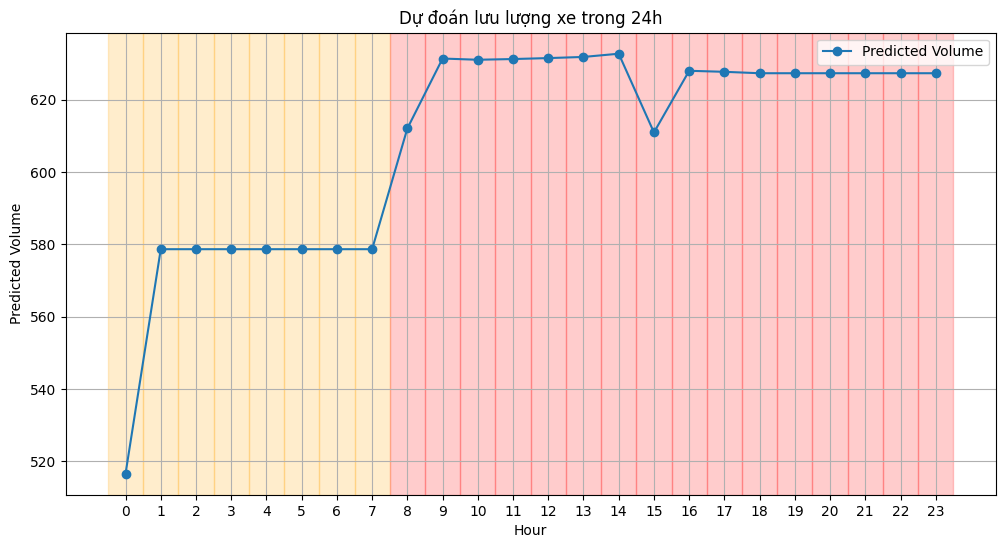

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo màu theo congestion_level
level_colors = {
    '1 - Rất thông thoáng': 'green',
    '2 - Thông thoáng': 'lime',
    '3 - Bình thường': 'yellow',
    '4 - Đông': 'orange',
    '5 - Rất đông': 'red'
}

plt.figure(figsize=(12,6))

# Vẽ đường volume
plt.plot(df_pred['hour'], df_pred['predicted_volume'], marker='o', label='Predicted Volume')

# Vẽ màu nền theo congestion_level
for i, row in df_pred.iterrows():
    plt.axvspan(row['hour']-0.5, row['hour']+0.5, color=level_colors[row['congestion_level']], alpha=0.2)

plt.xticks(range(0,24))
plt.xlabel('Hour')
plt.ylabel('Predicted Volume')
plt.title('Dự đoán lưu lượng xe trong 24h')
plt.grid(True)
plt.legend()
plt.show()


In [18]:
def predict_next_day_new(road_name, df, model_lstm, model_xgb, scaler_lstm,
                     features_lstm, target_col, n_steps, device):

    df_road = df[df['road_name'] == road_name].sort_values('hour').reset_index(drop=True)
    last_n_data = df_road[features_lstm].iloc[-n_steps:].copy()

    lstm_preds = []

    for i in range(24):
        last_n_data['hour'] = (last_n_data['hour'] + 1) % 24

        X_input_scaled = pd.DataFrame(scaler_lstm.transform(last_n_data), columns=features_lstm)
        X_input_tensor = torch.tensor(X_input_scaled.values.astype(np.float32)).unsqueeze(0).to(device)

        model_lstm.eval()
        with torch.no_grad():
            lstm_pred = model_lstm(X_input_tensor).cpu().numpy().flatten()[0]
        lstm_preds.append(lstm_pred)

        # Shift target
        last_n_data = last_n_data.shift(-1)
        last_n_data.iloc[-1, last_n_data.columns.get_loc(target_col)] = lstm_pred

    # Tạo DataFrame
    df_next = pd.DataFrame({'hour': np.arange(24)})

    xgb_features = [
        'hour', 'month', 'is_weekend', 'pedal_cycles', 'two_wheeled_motor_vehicles',
        'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'hgvs_2_rigid_axle', 'all_hgvs',
        'day_of_week_encoded', 'road_type_encoded', 'region_name_encoded',
        'local_authority_name_encoded', 'road_name_encoded', 'lstm_predicted_volume'
    ]

    for col in xgb_features:
        if col != 'lstm_predicted_volume' and col not in df_next.columns:
            df_next[col] = df_road[col].iloc[-1]

    df_next['lstm_predicted_volume'] = lstm_preds
    df_next['predicted_volume'] = model_xgb.predict(df_next[xgb_features])

    # Phân loại
    df_next['congestion_level'] = df_next['predicted_volume'].apply(
        lambda v: 1 if v < 100 else
                  2 if v < 250 else
                  3 if v < 400 else
                  4 if v < 600 else 5
    )

    # 🟢 thêm: volume trung bình 24h
    avg_volume = df_next['predicted_volume'].mean()
    avg_level = df_next['congestion_level'].mean()

    return df_next, avg_volume, avg_level


In [22]:
def predict_all_roads(df, model_lstm, model_xgb, scaler_lstm,
                      features_lstm, target_col, n_steps, device):

    road_list = df['road_name'].unique().tolist()
    results = []

    for road in road_list:
        try:
            # Chỉ lấy 1 biến DataFrame
            df_next = predict_next_day(
                road, df, model_lstm, model_xgb, scaler_lstm,
                features_lstm, target_col, n_steps, device
            )

            # Tính trung bình 24h
            avg_volume = df_next['predicted_volume'].mean()
            # Lấy congestion_level phổ biến nhất trong 24h
            avg_level = df_next['congestion_level'].mode()[0]

            results.append({
                'road_name': road,
                'avg_volume_24h': avg_volume,
                'avg_level_24h': avg_level
            })

            print(f"✔ Done: {road} => {avg_volume:.2f}, level={avg_level}")

        except Exception as e:
            print(f"❌ Error predicting {road}: {e}")

    return pd.DataFrame(results)

# --- Chạy ---
df_pred_all = predict_all_roads(
    df=df,
    model_lstm=model_lstm,
    model_xgb=model_xgb_stacked,
    scaler_lstm=scaler_lstm,
    features_lstm=features_lstm,
    target_col="all_motor_vehicles",
    n_steps=5,
    device=device
)

df_pred_all.head()


✔ Done: A3111 => -13.16, level=1 - Rất thông thoáng
✔ Done: A3112 => 53.73, level=1 - Rất thông thoáng
✔ Done: A3110 => 61.37, level=1 - Rất thông thoáng
✔ Done: A6097 => 415.28, level=4 - Đông
✔ Done: A3027 => 292.94, level=3 - Bình thường
✔ Done: M4 => 3094.57, level=5 - Rất đông
✔ Done: A5 => 423.34, level=4 - Đông
✔ Done: A40 => 1514.51, level=5 - Rất đông
✔ Done: A48 => 996.06, level=5 - Rất đông
✔ Done: A55 => 402.30, level=4 - Đông
✔ Done: A458 => 193.65, level=2 - Thông thoáng
✔ Done: A465 => 479.66, level=4 - Đông
✔ Done: A470 => 466.36, level=4 - Đông
✔ Done: A477 => 246.93, level=3 - Bình thường
✔ Done: A483 => 343.61, level=3 - Bình thường
✔ Done: A487 => 110.17, level=2 - Thông thoáng
✔ Done: A489 => 110.50, level=2 - Thông thoáng
✔ Done: A494 => 175.45, level=2 - Thông thoáng
✔ Done: A4051 => 1709.29, level=5 - Rất đông
✔ Done: A466 => 241.33, level=2 - Thông thoáng
✔ Done: A467 => 510.26, level=4 - Đông
✔ Done: A472 => 647.39, level=5 - Rất đông
✔ Done: A473 => 397.94, l

,road_name,avg_volume_24h,avg_level_24h
0,A3111,-13.159251,1 - Rất thông thoáng
1,A3112,53.727173,1 - Rất thông thoáng
2,A3110,61.369045,1 - Rất thông thoáng
3,A6097,415.282318,4 - Đông
4,A3027,292.940857,3 - Bình thường


In [23]:
# Lưu df_pred_all vào file CSV
df_pred_all.to_csv("df_pred_all.csv", index=False)

print("✅ Đã lưu df_pred_all vào df_pred_all.csv")


✅ Đã lưu df_pred_all vào df_pred_all.csv


## TRỌNG SỐ CHO NEO4J

In [24]:
from neo4j import GraphDatabase

In [25]:
# --- Kết nối ---
uri = "bolt://localhost:7687"
username = "neo4j"
password = "12345678"
driver = GraphDatabase.driver(uri, auth=(username, password))

In [26]:
# --- Hàm kiểm tra kết nối ---
def test_connection():
    try:
        with driver.session(database= "traffic-england-3") as session:
            # Truy vấn một node bất kỳ
            result = session.run("MATCH (n) RETURN DISTINCT labels(n) AS label LIMIT 10")
            print("✅ Kết nối thành công! Dưới đây là các loại node hiện có:")
            for record in result:
                print(" -", record["label"])
    except Exception as e:
        print("❌ Lỗi kết nối:", e)

# --- Gọi hàm ---
test_connection()

✅ Kết nối thành công! Dưới đây là các loại node hiện có:
 - ['Intersection']
 - ['Region']
 - ['Road']


In [27]:
def update_avg_weights(df_pred_all, database_name="traffic-england-3"):
    """
    Cập nhật trọng số trung bình 24h cho tất cả các tuyến đường vào Neo4j
    df_pred_all: DataFrame có các cột 'road_name', 'avg_volume_24h', 'avg_level_24h'
    """
    query = """
    MATCH (r:Road {name: $road_name})
    OPTIONAL MATCH (r)-[rel:CONNECTS_TO]->(i:Intersection)
    WITH r, collect(rel) AS rels
    FOREACH (rel IN rels |
        SET rel.weight = $avg_volume,
            rel.congestion_level = $avg_level,
            rel.last_updated = datetime()
    )
    """
    
    with driver.session(database=database_name) as session:
        for _, row in df_pred_all.iterrows():
            try:
                session.run(
                    query,
                    road_name=row['road_name'],
                    avg_volume=row['avg_volume_24h'],
                    avg_level=row['avg_level_24h']
                )
                print(f"✔ Updated: {row['road_name']} -> avg_volume={row['avg_volume_24h']:.2f}, avg_level={row['avg_level_24h']}")
            except Exception as e:
                print(f"❌ Error updating {row['road_name']}: {e}")

# --- Gọi hàm ---
update_avg_weights(df_pred_all)

✔ Updated: A3111 -> avg_volume=-13.16, avg_level=1 - Rất thông thoáng
✔ Updated: A3112 -> avg_volume=53.73, avg_level=1 - Rất thông thoáng
✔ Updated: A3110 -> avg_volume=61.37, avg_level=1 - Rất thông thoáng
✔ Updated: A6097 -> avg_volume=415.28, avg_level=4 - Đông
✔ Updated: A3027 -> avg_volume=292.94, avg_level=3 - Bình thường
✔ Updated: M4 -> avg_volume=3094.57, avg_level=5 - Rất đông
✔ Updated: A5 -> avg_volume=423.34, avg_level=4 - Đông
✔ Updated: A40 -> avg_volume=1514.51, avg_level=5 - Rất đông
✔ Updated: A48 -> avg_volume=996.06, avg_level=5 - Rất đông
✔ Updated: A55 -> avg_volume=402.30, avg_level=4 - Đông
✔ Updated: A458 -> avg_volume=193.65, avg_level=2 - Thông thoáng
✔ Updated: A465 -> avg_volume=479.66, avg_level=4 - Đông
✔ Updated: A470 -> avg_volume=466.36, avg_level=4 - Đông
✔ Updated: A477 -> avg_volume=246.93, avg_level=3 - Bình thường
✔ Updated: A483 -> avg_volume=343.61, avg_level=3 - Bình thường
✔ Updated: A487 -> avg_volume=110.17, avg_level=2 - Thông thoáng
✔ Upd

In [34]:
with driver.session(database="traffic-england-3") as session:
    result = session.run("MATCH (r:Road) RETURN r.name AS road LIMIT 25")
    for record in result:
        print(record['road'])


M4
M5
A38
A39
A352
A371
A380
A386
A387
A419
A420
A3026
A388
A338
A361
A36
A4
A37
A417
A4259
A363
A379
A395
A3072
A4173


In [35]:
import networkx as nx

# Tạo directed graph
G = nx.DiGraph()

with driver.session(database="traffic-england-3") as session:
    # Lấy tất cả các mối quan hệ CONNECTS_TO có trọng số
    query = """
    MATCH (r:Road)-[rel:CONNECTS_TO]->(i:Intersection)
    RETURN r.name AS road, i.name AS intersection, rel.weight AS weight
    """
    for record in session.run(query):
        G.add_edge(record['road'], record['intersection'], weight=record['weight'])

# Ví dụ: tìm đường ngắn nhất từ 'A1011' đến 'I1234'
path = nx.dijkstra_path(G, source='M4', target='A5', weight='weight')
print("Shortest path:", path)


Shortest path: ['M4', 'A4', 'A436', 'A44', 'A49', 'A5']


In [37]:
import networkx as nx

# G là directed graph đã có các edge với weight
source = 'A491'
target = 'A4051'
k = 5  # số đường đi tốt nhất muốn xem

# Lấy tất cả đường đi theo trọng số tăng dần
paths_generator = nx.shortest_simple_paths(G, source=source, target=target, weight='weight')

# Lấy top k đường đi
for idx, path in enumerate(paths_generator):
    if idx >= k:
        break
    # Tính tổng trọng số của đường đi
    total_weight = sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path)-1))
    print(f"Path {idx+1}: {path} | Total weight: {total_weight:.2f}")


Path 1: ['A491', 'A449', 'A472', 'A4042', 'A4051'] | Total weight: 2926.59
Path 2: ['A491', 'A456', 'A449', 'A472', 'A4042', 'A4051'] | Total weight: 3115.42
Path 3: ['A491', 'A458', 'A449', 'A472', 'A4042', 'A4051'] | Total weight: 3120.25
Path 4: ['A491', 'A456', 'A458', 'A449', 'A472', 'A4042', 'A4051'] | Total weight: 3309.07
Path 5: ['A491', 'A451', 'A449', 'A472', 'A4042', 'A4051'] | Total weight: 3344.50
